# Importación de librerías

In [1]:
import warnings
warnings.filterwarnings('ignore') 

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import os
import re # Expresiones regulares
from sklearn import preprocessing # LabelEncoder
import pickle #Guardado binario

In [3]:
data = pd.read_table("../Dataset/labeledEligibilitySample10k.csv", header = None)

In [4]:
print(data.shape)

(10000, 1)


### Se transforma la variable elegible (la salida) en 0 y 1

In [5]:
clin_trial = pd.DataFrame(np.array(data).reshape(10000,1), columns=['Description'])
#clin_trial[:].head(10)

In [6]:
clin_trial['Num'], clin_trial['ExtraPart'] = clin_trial['Description'].str.split(',', 1).str
clin_trial=clin_trial.drop(['Num'], axis=1)

clin_trial['Label'], clin_trial['TrashPart'] = clin_trial['ExtraPart'].str.split(',', 1).str
clin_trial['Eligible'] = clin_trial['Label'].str.extract('(\d)', expand=True)
clin_trial=clin_trial.drop(['Label'], axis=1)
clin_trial=clin_trial.drop(['ExtraPart'], axis=1)

clin_trial['Interventions'], clin_trial['Diagnoses'] = clin_trial['TrashPart'].str.split('.', 1).str
clin_trial=clin_trial.drop(['TrashPart'], axis=1)

clin_trial=clin_trial.drop(['Description'], axis=1)

#clin_trial.head(10)

In [7]:
# Se quita study interventions are puesto que está en todas las muestras de la varialbe Interventions
clin_trial['Interventions'] = clin_trial['Interventions'].str.replace("study interventions are\s", "")
clin_trial.sample(10)

,Eligible,Interventions,Diagnoses
2131,0,Prednisone,prostate cancer diagnosis and survival expect...
8423,1,Hydroxychloroquine,uncontrolled intercurrent illness including b...
9666,1,Lenvatinib,unresectable hepatocellular carcinoma hcc dia...
8439,1,Fludarabine,adult nasal type extranodal nk cell lymphoma ...
197,0,Interleukin-2,kidney cancer diagnosis and ecog performance ...
6712,1,Docetaxel,mucinous adenocarcinoma diagnosis and patient...
8405,1,Mycophenolate mofetil,stage iii grade one follicular lymphoma diagn...
222,0,Pancrelipase,metastatic pancreatic cancer diagnosis and pr...
7953,1,"""Antibodies, Monoclonal",brain cancer diagnosis and total bilirubin gr...
3247,0,"""Antibodies, Monoclonal",recurrent grade three follicular lymphoma dia...


In [9]:
# Se transforma todo a minúsculas
clin_trial['Interventions'] = clin_trial['Interventions'].str.lower() ##Todo a minúscula
clin_trial['Diagnoses'] = clin_trial['Diagnoses'].str.lower()     ##Todo a minúscula

#Se reemplazan vocales con tildes en ambas variables
clin_trial['Interventions'] = clin_trial['Interventions'].str.replace('[áäâà]', 'a', regex=True)
clin_trial['Interventions'] = clin_trial['Interventions'].str.replace('[éêèë]', 'e', regex=True)
clin_trial['Interventions'] = clin_trial['Interventions'].str.replace('[íïìî]', 'i', regex=True)
clin_trial['Interventions'] = clin_trial['Interventions'].str.replace('[óôòö]', 'o', regex=True)
clin_trial['Interventions'] = clin_trial['Interventions'].str.replace('[úûùü]', 'u', regex=True)
clin_trial['Interventions'] = clin_trial['Interventions'].str.replace('["]', '', regex=True)

clin_trial['Diagnoses'] = clin_trial['Diagnoses'].str.replace('[áäâà]', 'a', regex=True)
clin_trial['Diagnoses'] = clin_trial['Diagnoses'].str.replace('[éêèë]', 'e', regex=True)
clin_trial['Diagnoses'] = clin_trial['Diagnoses'].str.replace('[íïìî]', 'i', regex=True)
clin_trial['Diagnoses'] = clin_trial['Diagnoses'].str.replace('[óôòö]', 'o', regex=True)
clin_trial['Diagnoses'] = clin_trial['Diagnoses'].str.replace('[úûùü]', 'u', regex=True)
clin_trial['Diagnoses'] = clin_trial['Diagnoses'].str.replace('^\s', '', regex=True)
clin_trial['Diagnoses'] = clin_trial['Diagnoses'].str.replace('["]', '', regex=True)
clin_trial['Diagnoses'] = clin_trial['Diagnoses'].str.replace('[;]', '', regex=True)

#clin_trial.sample(10)

In [10]:
# Total de categorías diferentes en la variable Interventions
len(np.unique(clin_trial['Interventions'])) 

1426

In [12]:
# Total de categorías diferentes en la variable Diagnoses
len(np.unique(clin_trial['Diagnoses']))

9786

## Codificación de la variable Interventions

In [14]:
labels = np.unique(clin_trial['Interventions'])

lb_interventions = preprocessing.LabelEncoder()
lb_interventions.fit(labels)
clin_trial['Interventions'] = lb_interventions.transform(clin_trial['Interventions']) 

# Remover Stop Words

## Preliminares

In [15]:
# Se carga la libreria
from nltk.corpus import stopwords

# Se debe descargar el conjunto de 'Stop Words' la primera vez
import nltk
nltk.download('stopwords')

#Se carga la librería de lematización
#PONER conda install -c conda-forge spacy EN ANACONDA PROMPT
# Y python -m spacy download en_core_web_sm

#Se carga la librería de lematización
import spacy
nlp = spacy.load("en_core_web_sm")

#Se carga la librería de stemming y se inicializa el stemmer
import nltk
from nltk import SnowballStemmer
stemmer=SnowballStemmer('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\danie\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Crear las palabras Token

## Lematización

"Dada una forma flexionada (es decir, en plural, en femenino, conjugada, etc), hallar el lema correspondiente. El lema es la forma que por convenio se acepta como representante de todas las formas flexionadas de una misma palabra. Es decir, el lema de una palabra es la palabra que nos encontraríamos como entrada en un diccionario tradicional: singular para sustantivos, masculino singular para adjetivos, infinitivo para verbos." -Wikipedia

In [16]:
#https://medium.com/qu4nt/reducir-el-número-de-palabras-de-un-texto-lematización-y-radicalización-stemming-con-python-965bfd0c69fa
toks = []

for sample in clin_trial['Diagnoses']:
    words = nlp(sample)
    lemma = [tok.lemma_.lower() for tok in words]
    #print(lemma)
    toks.append(lemma)
    

## Cargar las Stop Words

In [17]:
# Carga las Stop Words en inglés
stop_words = stopwords.words('english')

## Estaría bien revisar este conjunto 'english'. Pero supongo que es el más útil para nuestro caso también.
# Imprime algunas Stop Words
#stop_words[:100]

## Remover las Stop Words

In [18]:
tokens = []
for tok in toks:
    clean_word = [word for word in tok if word not in stop_words]
    tokens.append(clean_word)

## Stemming

"Es un método para reducir una palabra a su raíz o (en inglés) a un stem." - Wikipedia

In [19]:
stemms = []
for tok in tokens:
    var = [stemmer.stem(token) for token in tok]
    stemms.append(var)

In [20]:
#Guardar las stemms

fichero_stemms = open("archivo_stemms", "wb")
pickle.dump(stemms, fichero_stemms)

fichero_stemms.close()
del fichero_stemms

# TF-IDF 
Term frequency – Inverse document frequency

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [21]:
#Cargar los stemms

fichero = open("archivo_stemms", "rb")
stemms = pickle.load(fichero)

fichero.close()

In [22]:
stemmsT = [ ' '.join(stemms[item]) for item in range (len(stemms))] #Se transforma de lista de listas a una lista

In [24]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(stemmsT)

In [25]:
cols = vectorizer.get_feature_names()
dense = X.todense()
denselist = dense.tolist()

In [26]:
df = pd.DataFrame(data=denselist, columns= cols)

In [27]:
del clin_trial['Diagnoses']
df = pd.concat([clin_trial, df], axis=1)

In [28]:
df.to_hdf('df_prueba.h5', key = 'clin_trial')

# Ordenar y eliminar palabras

In [29]:
df = pd.read_hdf('df_prueba.h5', 'clin_trial')

In [30]:
eligible = df['Eligible'].values #Para ver las palabras por clase

dict_0 = {}
dict_1 = {}

for col in df:
    if(col == 'Eligible' or col == 'Interventions'):
        continue
    ar = df[col].values
    condlist = [(eligible == "1") & (ar != 0.0), (eligible == "0") & (ar != 0.0)]
    choicelist = [1, 2]
    res = np.select(condlist, choicelist)
    
    dict_0[col] = len(res[res==2])
    dict_1[col] = len(res[res==1])
    
#     print(col + " tiene ", len(res[res==2]), " apariciones en la clase 0")
#     print(col + " tiene ", len(res[res==1]), " apariciones en la clase 1 \n")

In [31]:
final_words = []
for a,b in zip (dict_0, dict_1): #Para imprimir las palabras
    if((dict_0[a]/(dict_0[a]+dict_1[b])<=0.35 or dict_0[a]/(dict_0[a]+dict_1[b])>=0.65) and (dict_0[a]+dict_1[b])>=12):
#         anterior con 0.37, 0.63, 11
#         print(dict_0[a]/(dict_0[a]+dict_1[b]))
#print(a + " tiene ", dict_0[a], " muestras en la clase 0 \n" + b + " tiene ", dict_1[b], " muestras en la clase 1")
        final_words.append(a)

In [32]:
len(final_words)

657

In [33]:
final_words.insert(0,'Eligible')
final_words.insert(1,'Interventions')

In [34]:
aux = df
for word in df:
    if word not in final_words:
        del aux[word]

In [35]:
print(aux.shape)
df = aux

(10000, 659)


In [36]:
print(len(dict_0), len(final_words))

5264 659


In [37]:
df

,Eligible,Interventions,abdomin,abl,abscess,absolut,absorpt,abstin,accord,accur,...,withdraw,within,woman,wort,would,wound,write,york,zero,zubrod
0,0,464,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
1,0,101,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
2,0,349,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
3,0,1052,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.099676,0.0
4,0,708,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1,1109,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
9996,1,200,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
9997,1,1201,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.210823,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
9998,1,939,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.366276,0.0,0.0,0.000000,0.0


# Guardado del modelo

In [38]:
df.to_hdf('prueba.h5', key = 'clin_trial')

In [39]:
df = pd.read_hdf('prueba.h5', 'clin_trial')

In [40]:
df

,Eligible,Interventions,abdomin,abl,abscess,absolut,absorpt,abstin,accord,accur,...,withdraw,within,woman,wort,would,wound,write,york,zero,zubrod
0,0,464,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
1,0,101,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
2,0,349,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
3,0,1052,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.099676,0.0
4,0,708,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1,1109,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
9996,1,200,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
9997,1,1201,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.210823,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0
9998,1,939,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.366276,0.0,0.0,0.000000,0.0


# Algoritmo de selección

In [41]:
from sklearn.preprocessing import MinMaxScaler # Escala los datos
from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
import scikitplot as skplt 
from string import ascii_uppercase 
# import seaborn as sns
import qgrid
import time
#from sklearn.externals import joblib # Para guardar el modelo
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

from scipy import stats #Para la moda

In [42]:
from sklearn.model_selection import ShuffleSplit
from sklearn.linear_model import LogisticRegression

In [43]:
clin_trial_values = df.values
Y = clin_trial_values[:, 0]
Y = Y.astype(int)
X = clin_trial_values[:, 1:]

In [44]:
def classification_error(y_est, y_real):
    err = 0
    for y_e, y_r in zip(y_est, y_real):

        if y_e != y_r:
            err += 1

    return err/np.size(y_est)

In [45]:
def plot_roc(Xtest, Ytest, probs, xlabel):
    ns_probs = [0 for _ in range(len(Ytest))]
    
    probs = probs[:, 1]
    ns_auc = roc_auc_score(Ytest, ns_probs)
    auc = roc_auc_score(Ytest, probs)  

    print('No Skill: ROC AUC=%.3f' % (ns_auc))
    print(xlabel, 'ROC AUC=%.3f' % (auc))

    ns_fpr, ns_tpr, _ = roc_curve(Ytest, ns_probs)
    fpr, tpr, _ = roc_curve(Ytest, probs)   

    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    plt.plot(fpr, tpr, marker='.', label= xlabel)

    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # show the legend
    plt.legend()
    # show the plot
    plt.show()

# Naive Bayes

In [46]:
from sklearn.preprocessing import MinMaxScaler # Escala los datos
from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
import scikitplot as skplt 
from string import ascii_uppercase 
# import seaborn as sns
import qgrid
import time
#from sklearn.externals import joblib # Para guardar el modelo
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [47]:
from sklearn.naive_bayes import GaussianNB

In [48]:
def model_NB(impresion = False):

    tiempo_i = time.time()

    accuracy_list = np.zeros([4])
    precision_list = np.zeros([4,2])
    recall_list = np.zeros([4,2])
    f_list = np.zeros([4,2]) 
    errores = np.zeros(4)
    nb = GaussianNB()
    for j in range(4):
        Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.25) # Modificar metodología de validación
        scaler = MinMaxScaler()#Escala entre 0 y 1
        Xtrain = scaler.fit_transform(Xtrain)
        Xtest = scaler.transform(Xtest)

        nb.fit(Xtrain, Ytrain)
        pred = nb.predict(Xtest)
        
        #code for calculating accuracy 
        _accuracy_ = accuracy_score(Ytest, pred, normalize=True)
        accuracy_list[j] = _accuracy_

        #code for calculating recall 
        _recalls_ = recall_score(Ytest, pred, average=None)
        recall_list[j] = _recalls_

        #code for calculating precision 
        _precisions_ = precision_score(Ytest, pred, average=None)
        precision_list[j] = _precisions_
        
        _f_score_ = f1_score(Ytest, pred, average=None)
        f_list[j] = _f_score_
                
        errores[j] = classification_error(pred, Ytest)
          
    if impresion == True:
        #Curva ROC
        nb_probs = nb.predict_proba(Xtest)
        
        plot_roc(Xtest, Ytest, nb_probs, "Naive Bayes")
#         auc = roc_auc_score(Ytest, pred)
#         print('AUC: %.2f' % auc)
#         fpr, tpr, thresholds = roc_curve(Ytest, pred)
#         plot_roc_curve(fpr, tpr)
        #Matriz de confusión
        skplt.metrics.plot_confusion_matrix(Ytest, pred, normalize=True)

    return str(np.mean(accuracy_list)), str(np.std(accuracy_list)), str(np.mean(recall_list)), str(np.std(recall_list)), str(np.mean(precision_list)), str(np.std(precision_list)),  str(np.mean(f_list)), str(np.std(f_list)), str(np.mean(errores)), str(np.std(errores)), str(time.time()-tiempo_i)

No Skill: ROC AUC=0.500
Naive Bayes ROC AUC=0.816


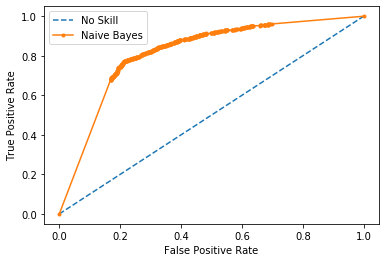

Eficiencia 0.7584  Int_Eficiencia 0.009955902771722874  Sensibilidad 0.7586131720141525  Int_Sensibilidad 0.05132252166487334  Precision 0.7610856349041366  Int_Precision 0.02870449557626516  F-Score 0.757838084309258  Int_F-Score 0.015685883375918346  Error_Prueba 0.24159999999999998  Int_Error 0.009955902771722923  Tiempo ejecución 2.404982566833496


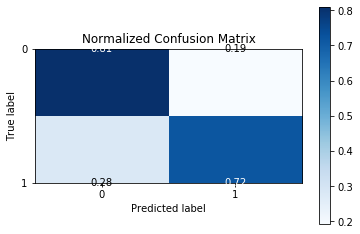

In [49]:
Acc, IntAcc, Sen, IntSen, Pre, IntPre, f, IntF, error, stdError, tiempo = model_NB(impresion = True)
print('Eficiencia',Acc, ' Int_Eficiencia', IntAcc,' Sensibilidad', Sen, ' Int_Sensibilidad',IntSen,' Precision', Pre, ' Int_Precision',IntPre,' F-Score', f, ' Int_F-Score',IntF,' Error_Prueba', error,' Int_Error', stdError,' Tiempo ejecución', tiempo)

# Logistic Regression

In [50]:
from sklearn.model_selection import ShuffleSplit
from sklearn.linear_model import LogisticRegression

In [51]:
def LRC(c, slv, impresion = False):

    tiempo_i = time.time()
    
    accuracy_list = np.zeros([4])
    precision_list = np.zeros([4,2])
    recall_list = np.zeros([4,2])
    f_list = np.zeros([4,2]) 
    errores = np.zeros(4)
    LR = LogisticRegression(C=c, solver=slv, max_iter = 200)
    for j in range(4):
        Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.25) # Modificar metodología de validación
        scaler = MinMaxScaler()#Escala entre 0 y 1
        Xtrain = scaler.fit_transform(Xtrain)
        Xtest = scaler.transform(Xtest)
        
        LR.fit(Xtrain, Ytrain)
        pred = LR.predict(Xtest)
        
        #code for calculating accuracy 
        _accuracy_ = accuracy_score(Ytest, pred, normalize=True)
        accuracy_list[j] = _accuracy_

        #code for calculating recall 
        _recalls_ = recall_score(Ytest, pred, average=None)
        recall_list[j] = _recalls_

        #code for calculating precision 
        _precisions_ = precision_score(Ytest, pred, average=None)
        precision_list[j] = _precisions_
        
        _f_score_ = f1_score(Ytest, pred, average=None)
        f_list[j] = _f_score_

                
        errores[j] = classification_error(pred, Ytest)
           
    if impresion == True:
        #Curva ROC
        
        lr_probs = LR.predict_proba(Xtest)
        
        plot_roc(Xtest, Ytest, lr_probs, "Logistic Regression")
        
#         auc = roc_auc_score(Ytest, pred)
#         print('AUC: %.2f' % auc)
#         fpr, tpr, thresholds = roc_curve(Ytest, pred)
#         plot_roc_curve(fpr, tpr)
        #Matriz de confusión
        skplt.metrics.plot_confusion_matrix(Ytest, pred, normalize=True)

    return str(np.mean(accuracy_list)), str(np.std(accuracy_list)), str(np.mean(recall_list)), str(np.std(recall_list)), str(np.mean(precision_list)), str(np.std(precision_list)),  str(np.mean(f_list)), str(np.std(f_list)), str(np.mean(errores)), str(np.std(errores)), str(time.time()-tiempo_i)

No Skill: ROC AUC=0.500
Logistic Regression ROC AUC=0.863


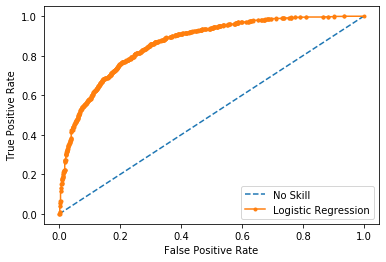

Eficiencia 0.7835  Int_Eficiencia 0.0048363209157375  Sensibilidad 0.783426909130698  Int_Sensibilidad 0.020154406585764367  Precision 0.7838630444592879  Int_Precision 0.01220633912027487  F-Score 0.783357536357792  Int_F-Score 0.007303273979255575  Error_Prueba 0.2165  Int_Error 0.0048363209157375004  Tiempo ejecución 2.0068342685699463


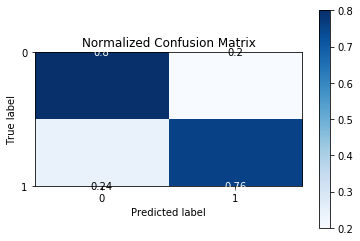

In [52]:
Acc, IntAcc, Sen, IntSen, Pre, IntPre, f, IntF, error, stdError, tiempo = LRC(1, 'liblinear', impresion = True)
print('Eficiencia',Acc, ' Int_Eficiencia', IntAcc,' Sensibilidad', Sen, ' Int_Sensibilidad',IntSen,' Precision', Pre, ' Int_Precision',IntPre,' F-Score', f, ' Int_F-Score',IntF,' Error_Prueba', error,' Int_Error', stdError,' Tiempo ejecución', tiempo)

In [53]:
pd.options.mode.chained_assignment = None

#randn = np.random.randn
df_types = pd.DataFrame({
    'Tipo de solver' : pd.Series(['newton-cg', 'newton-cg', 'newton-cg', 'newton-cg', 'newton-cg', 'newton-cg', 
                          'lbfgs', 'lbfgs', 'lbfgs', 'lbfgs', 'lbfgs', 'lbfgs', 
                          'liblinear', 'liblinear', 'liblinear','liblinear','liblinear','liblinear',
                          'sag','sag','sag','sag','sag','sag',
                          'saga','saga','saga','saga','saga','saga']),
    'Valor de regularización' : pd.Series([0.1,0.5,1,1.5,2,3,
                                           0.1,0.5,1,1.5,2,3,
                                           0.1,0.5,1,1.5,2,3,
                                           0.1,0.5,1,1.5,2,3,
                                           0.1,0.5,1,1.5,2,3])})
df_types["Eficiencia"] = ""
df_types["Int_Eficiencia"] = ""
df_types["Sensibilidad"] = ""
df_types["Int_Sensibilidad"] = ""
df_types["Precision"] = ""
df_types["Int_Precision"] = ""
df_types["F-Score"] = ""
df_types["Int_F-Score"] = ""
df_types["Error_Prueba"] = ""
df_types["Int_error"] = ""
df_types["Tiempo de ejecución"] = ""
df_types.set_index(['Tipo de solver', 'Valor de regularización'], inplace=True)

i = 0
for k, n in df_types.index:
    Acc, IntAcc, Sen, IntSen, Pre, IntPre, f, IntF, error, stdError, tiempo = LRC(n, k, impresion = False)
    df_types["Eficiencia"][i] = Acc
    df_types["Int_Eficiencia"][i] = IntAcc
    df_types["Sensibilidad"][i] = Sen
    df_types["Int_Sensibilidad"][i] = IntSen
    df_types["Precision"][i] = Pre
    df_types["Int_Precision"][i] = IntPre
    df_types["F-Score"][i] = f
    df_types["Int_F-Score"][i] = IntF
    df_types["Error_Prueba"][i] = error
    df_types["Int_error"][i] = stdError
    df_types["Tiempo de ejecución"][i] = tiempo
    
    i += 1
    
qgrid_widget = qgrid.show_grid(df_types, show_toolbar=False)
qgrid_widget

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [54]:
qgrid_widget.get_changed_df()

Eficiencia  \
Tipo de solver Valor de regularización                       
newton-cg      0.1                                  0.7714   
               0.5                                   0.782   
               1.0                      0.7831000000000001   
               1.5                                  0.7816   
               2.0                                  0.7865   
               3.0                      0.7788999999999999   
lbfgs          0.1                                  0.7748   
               0.5                      0.7809999999999999   
               1.0                                  0.7892   
               1.5                      0.7829999999999999   
               2.0                      0.7751000000000001   
               3.0                                  0.7697   
liblinear      0.1                      0.7794000000000001   
               0.5                                  0.7745   
               1.0                                  0.7761   
               1.5                      0.7740999999999999   
               2.0                                  0.7759   
               3.0                                  0.7788   
sag            0.1                      0.7757000000000001   
               0.5                                  0.7809   
               1.0                      0.7868999999999999   
               1.5                                  0.7726   
               2.0                                  0.7783   
               3.0                      0.7740999999999999   
saga           0.1                                  0.7696   
               0.5                      0.7828999999999999   
               1.0                                  0.7764   
               1.5                      0.7736000000000001   
               2.0                                  0.7796   
               3.0                                  0.7835   

                                               Int_Eficiencia  \
Tipo de solver Valor de regularización                          
newton-cg      0.1                       0.004529900661162454   
               0.5                       0.006343500610861461   
               1.0                        0.00538423625038872   
               1.5                       0.009947864092356703   
               2.0                       0.006790434448545948   
               3.0                      0.0023216373532487645   
lbfgs          0.1                       0.007076722405181644   
               0.5                       0.008623224454924052   
               1.0                       0.007509993342207435   
               1.5                       0.007334848328356886   
               2.0                       0.007463913182774842   
               3.0                        0.00442153819388684   
liblinear      0.1                       0.003280243893371339   
               0.5                       0.006263385665915844   
               1.0                      0.0038405728739343177   
               1.5                       0.006364746656387836   
               2.0                       0.008981647955692734   
               3.0                        0.00609918027279075   
sag            0.1                       0.004493328387732204   
               0.5                       0.005588380803059127   
               1.0                       0.004624932431938835   
               1.5                      0.0020880613017821327   
               2.0                      0.0024062418831032094   
               3.0                       0.003179622619116915   
saga           0.1                       0.006368673331236235   
               0.5                       0.005443344560102709   
               1.0                       0.004399999999999982   
               1.5                      0.0035665109000254038   
               2.0                       0.014458215657542276   
               3.0                       0.01050

# Random Forest

In [55]:
from sklearn.ensemble import RandomForestClassifier # Se llama a la librería del método Random Forest

In [56]:
def model_RF(estimadores, caracteristicas, impresion = False):
        
    tiempo_i = time.time()
    
    accuracy_list = np.zeros([4])
    precision_list = np.zeros([4,2])
    recall_list = np.zeros([4,2])
    f_list = np.zeros([4,2]) 
    errores = np.zeros(4)
    
    RF = RandomForestClassifier(n_estimators=estimadores, max_features =caracteristicas, n_jobs = -1)
    
    for j in range(4):
        Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.25) # Modificar metodología de validación
        scaler = MinMaxScaler()#Escala entre 0 y 1
        Xtrain = scaler.fit_transform(Xtrain)
        Xtest = scaler.transform(Xtest)
        
        RF.fit(Xtrain, Ytrain)
        pred = RF.predict(Xtest)
        
        #code for calculating accuracy 
        _accuracy_ = accuracy_score(Ytest, pred, normalize=True)
        accuracy_list[j] = _accuracy_

        #code for calculating recall 
        _recalls_ = recall_score(Ytest, pred, average=None)
        recall_list[j] = _recalls_

        #code for calculating precision 
        _precisions_ = precision_score(Ytest, pred, average=None)
        precision_list[j] = _precisions_
        
        _f_score_ = f1_score(Ytest, pred, average=None)
        f_list[j] = _f_score_

        
        errores[j] = classification_error(pred, Ytest)
       
    
    if impresion == True:
        #Curva ROC
        
        rf_probs = RF.predict_proba(Xtest)
        
        plot_roc(Xtest, Ytest, rf_probs, "Random Forest")
#         auc = roc_auc_score(Ytest, pred)
#         print('AUC: %.2f' % auc)
#         fpr, tpr, thresholds = roc_curve(Ytest, pred)
#         plot_roc_curve(fpr, tpr)
        #Matriz de confusión
        skplt.metrics.plot_confusion_matrix(Ytest, pred, normalize=True)

    return str(np.mean(accuracy_list)), str(np.std(accuracy_list)), str(np.mean(recall_list)), str(np.std(recall_list)), str(np.mean(precision_list)), str(np.std(precision_list)),  str(np.mean(f_list)), str(np.std(f_list)), str(np.mean(errores)), str(np.std(errores)), str(time.time()-tiempo_i)
    

In [61]:
Acc, IntAcc, Sen, IntSen, Pre, IntPre, f, IntF, error, stdError, tiempo = RF(100, 5, impresion = True)
print('Eficiencia',Acc, ' Int_Eficiencia', IntAcc,' Sensibilidad', Sen, ' Int_Sensibilidad',IntSen,' Precision', Pre, ' Int_Precision',IntPre,' F-Score', f, ' Int_F-Score',IntF,' Error_Prueba', error,' Int_Error', stdError,' Tiempo ejecución', tiempo)

NameError: name 'RF' is not defined

In [59]:
pd.options.mode.chained_assignment = None

randn = np.random.randn
df_types = pd.DataFrame({
    'Numero de arboles' : pd.Series([5,5,5,5,5,5,5,
                                     10,10,10,10,10,10,10,
                                     20,20,20,20,20,20,20,
                                     50,50,50,50,50,50,50,
                                     100,100,100,100,100,100,100]), 
    'Variables analizadas por nodo' : pd.Series([10,50,100,200,250,350,500,
                                                 10,50,100,200,250,350,500,
                                                 10,50,100,200,250,350,500,
                                                 10,50,100,200,250,350,500,
                                                 10,50,100,200,250,350,500])})
df_types["Eficiencia"] = ""
df_types["Int_Eficiencia"] = ""
df_types["Sensibilidad"] = ""
df_types["Int_Sensibilidad"] = ""
df_types["Precision"] = ""
df_types["Int_Precision"] = ""
df_types["F-Score"] = ""
df_types["Int_F-Score"] = ""
df_types["Error_Prueba"] = ""
df_types["Int_error"] = ""
df_types["Tiempo de ejecución"] = ""
df_types.set_index(['Numero de arboles','Variables analizadas por nodo'], inplace=True)

for n, k in df_types.index:
    Acc, IntAcc, Sen, IntSen, Pre, IntPre, f, IntF, error, stdError, tiempo = model_RF(n, k, impresion = False)
    df_types["Eficiencia"][n,k] = Acc
    df_types["Int_Eficiencia"][n,k] = IntAcc
    df_types["Sensibilidad"][n,k] = Sen
    df_types["Int_Sensibilidad"][n,k] = IntSen
    df_types["Precision"][n,k] = Pre
    df_types["Int_Precision"][n,k] = IntPre
    df_types["F-Score"][n,k] = f
    df_types["Int_F-Score"][n,k] = IntF
    df_types["Error_Prueba"][n,k] = error
    df_types["Int_error"][n,k] = stdError
    df_types["Tiempo de ejecución"][n,k] = tiempo


#df_types.sort_index(inplace=True)
qgrid_widget = qgrid.show_grid(df_types, show_toolbar=False)
qgrid_widget

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [60]:
qgrid_widget.get_changed_df()

Eficiencia  \
Numero de arboles Variables analizadas por nodo                       
5                 10                                          0.768   
                  50                                         0.7525   
                  100                            0.7513999999999998   
                  200                                        0.7476   
                  250                                        0.7521   
                  350                                         0.753   
                  500                            0.7571000000000001   
10                10                                         0.7814   
                  50                                         0.7699   
                  100                            0.7666000000000001   
                  200                                        0.7644   
                  250                                         0.763   
                  350                                        0.7581   
                  500                                        0.7652   
20                10                                         0.7821   
                  50                                         0.7794   
                  100                                        0.7754   
                  200                            0.7648999999999999   
                  250                                        0.7682   
                  350                                        0.7658   
                  500                                        0.7672   
50                10                                         0.7868   
                  50                                         0.7858   
                  100                                        0.7722   
                  200                                        0.7741   
                  250                                        0.7719   
                  350                            0.7712000000000001   
                  500                                        0.7662   
100               10                                         0.7965   
                  50                                         0.7856   
                  100                                         0.785   
                  200                                        0.7781   
                  250                            0.7715000000000001   
                  350                                        0.7756   
                  500                            0.7767999999999999   

                                                        Int_Eficiencia  \
Numero de arboles Variables analizadas por nodo                          
5                 10                              0.007720103626247511   
                  50                              0.005094114250779986   
                  100                              0.00980408078302091   
                  200                             0.008527602242131145   
                  250                              0.00986458311334037   
                  350                              0.00567450438364446   
                  500                             0.005867708240872232   
10                10                               0.00819999999999999   
                  50                              0.003923009049186621   
                  100                             0.006636264009214825   
                  200                              0.01107429455992571   
                  250                             0.002849561369754992   
                  350                             0.002762245463386639   
                  500                             0.008611620056644405   
20                10                             0.0021610182784974332   
                  50                              0.005806892456383193   
                  100                             0.012577758146824089   
                  200  

# Red neuronal recurrente

In [ ]:
Acc, IntAcc, Sen, IntSen, Pre, IntPre, f, IntF, error, stdError, tiempo = LRC(1, 'liblinear', impresion = True)
print('Eficiencia',Acc, ' Int_Eficiencia', IntAcc,' Sensibilidad', Sen, ' Int_Sensibilidad',IntSen,' Precision', Pre, ' Int_Precision',IntPre,' F-Score', f, ' Int_F-Score',IntF,' Error_Prueba', error,' Int_Error', stdError,' Tiempo ejecución', tiempo)